In [2]:
# import
import os
import cv2
import math
import matplotlib.pyplot as plt
from abc import abstractmethod

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from PIL import Image
import requests
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [3]:
# 高斯噪声对应函数 Unet定义
def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    Args:
        timesteps (Tensor): a 1-D Tensor of N indices, one per batch element. These may be fractional.
        dim (int): the dimension of the output.
        max_period (int, optional): controls the minimum frequency of the embeddings. Defaults to 10000.

    Returns:
        Tensor: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, t):
        """
        Apply the module to `x` given `t` timestep embeddings.
        """
        pass


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that support it as an extra input.
    """

    def forward(self, x, t):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, t)
            else:
                x = layer(x)
        return x


def norm_layer(channels):
    return nn.GroupNorm(32, channels)


class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )

        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()


    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        """
        Attention block with shortcut

        Args:
            channels (int): channels
            num_heads (int, optional): attention heads. Defaults to 1.
        """
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x


class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)
def linear_beta_schedule(timesteps):
    """
    beta schedule
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas

        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))

        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )

    def _extract(self, a, t, x_shape):
        # get the param of given timestep t
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    def q_sample(self, x_start, t, noise=None):
        # forward diffusion (using the nice property): q(x_t | x_0)
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def q_mean_variance(self, x_start, t):
        # Get the mean and variance of q(x_t | x_0).
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def predict_start_from_noise(self, x_t, t, noise):
        # compute x_0 from x_t and pred noise: the reverse of `q_sample`
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # compute predicted mean and variance of p(x_{t-1} | x_t)
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # denoise_step: sample x_{t-1} from x_t and pred_noise
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        # denoise: reverse diffusion
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=self.timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs

    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        # sample new images
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

    def train_losses(self, model, x_start, t):
        # compute train losses
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        denoise_images = model(x_noisy, t)
        predicted_noise=x_noisy-denoise_images
        loss = F.mse_loss(x_start,denoise_images)
        return loss,denoise_images,predicted_noise

class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding
    """
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2

        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )

        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        """Apply the model to an input batch.

        Args:
            x (Tensor): [N x C x H x W]
            timesteps (Tensor): a 1-D batch of timesteps.

        Returns:
            Tensor: [N x C x ...]
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)


In [4]:
# 模型训练参数定义

#初始化参数
batch_size = 4
timesteps = 200
image_size=128

#前向加噪（使用高斯噪声）
gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)

#定义处理方式
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

weights = torch.tensor([0.299, 0.587, 0.114]).view(1, 1, 1, 3)
# 检查系统上是否有可用的GPU设备
if torch.cuda.is_available():
    # 设置要使用的GPU设备为GPU 0（如果只有一个GPU）
    device = torch.device("cuda:0")
    print("使用的GPU设备:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")
    print("没有可用的GPU，将使用CPU")

使用的GPU设备: NVIDIA GeForce RTX 4070 Laptop GPU


In [12]:
#创建一个能够将加噪后的图往有病症的方向生成的模型
#checkpoint1 = torch.load('.\MyDrive\DataSet\model_train4.pth')
torch.cuda.empty_cache()
model_have = UNetModel(
    in_channels=3,
    model_channels=96,
    out_channels=3,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model_have.to(device)
#model_have.load_state_dict(checkpoint1)

没有可用的GPU，将使用CPU


In [1]:
#读取有病症的医学图像作为训练集，并以原图像作为目标
dataset_have = datasets.ImageFolder('.\MyDrive\DataSet\images_isic2018', transform=transform)
train_have_loader = torch.utils.data.DataLoader(dataset_have, batch_size=batch_size, shuffle=True)

#定义优化器
optimizer_have = torch.optim.Adam(model_have.parameters(), lr=5e-4)
epochs =20
for epoch in range(epochs):
    print("epoch:",end=' ')
    print(epoch)
    for step_have_train, (images_have_train,labels_have_train) in enumerate(train_have_loader):
        #梯度清零
        optimizer_have.zero_grad()
        print(images_have_train.shape)
        #batch_size = images_have_train.shape[0]
        #images_have_train = images_have_train.to(device)
        #对每个样本进行随机t_have步加噪
        t_have_train = torch.randint(0,timesteps, (batch_size,), device=device).long()
        #计算模型model_have的训练误差，去噪后的伪原图，预测的噪声
        (loss_have_train,denoise_images_have_train,pnoise_have_train) = gaussian_diffusion.train_losses(model_have, images_have_train, t_have_train)
        if step_have_train == 20:
             # 假设 denoise_images_have_train 是一个四维张量 (batch_size, height, width, channels)
             sample_image = denoise_images_have_train[0].permute(1, 2, 0).squeeze().cpu().detach().numpy()  # 取第一个样本
             sample_image = (sample_image + 1) * 127.5  # 数据范围调整
             plt.imshow(sample_image.astype(int), aspect='auto')
             plt.axis("off")
             plt.show()  # 显示图像
        if step_have_train == 20:
             # 假设 denoise_images_have_train 是一个四维张量 (batch_size, height, width, channels)
             sample_image = images_have_train[0].permute(1, 2, 0).squeeze().cpu().detach().numpy()  # 取第一个样本
             sample_image = (sample_image + 1) * 127.5  # 数据范围调整
             plt.imshow(sample_image.astype(int), aspect='auto')
             plt.axis("off")
             plt.show()  # 显示图像

        print("Loss:", loss_have_train.item())
        print(step_have_train)

        #反向传播
        loss_have_train.backward()
        #更新参数
        optimizer_have.step()
#保存训练后的参数
torch.save(model_have.state_dict(), '.\MyDrive\DataSet\model_train5.pth')

NameError: name 'datasets' is not defined

In [ ]:
dataset_no_train = datasets.ImageFolder('.\MyDrive\DataSet\images_isic2016_no', transform=transform)
train_no_loader = torch.utils.data.DataLoader(dataset_no_train, batch_size=batch_size, shuffle=False)
dataset_no_train_target = datasets.ImageFolder('.\MyDrive\DataSet\images_isic2016_no', transform=transform)
train_no_target_loader = torch.utils.data.DataLoader(dataset_no_train_target, batch_size=batch_size, shuffle=False)
#训练加噪后生成没有病症图片的模型
model_no = UNetModel(
    in_channels=3,
    model_channels=96,
    out_channels=3,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
optimizer_no = torch.optim.Adam(model_no.parameters(), lr=5e-4)

epochs = 200
for epoch in range(epochs):
    print("epoch:", end=' ')
    print(epoch)
    for step_no_train, ((images_no_train, labels_no_train),(images_no_train_target,labels_no_train_target)) in enumerate(zip(train_no_loader,train_no_target_loader)):
        optimizer_no.zero_grad()
        #print(labels_no_train)
        #batch_size = images_no_train.shape[0]
        images_no_train = images_no_train.to(device)
        images_no_train_target = images_no_train_target.to(device)
        model_no.to(device)
        # sample t uniformally for every example in the batchQA
        t_no_train = torch.randint(0, 500, (batch_size,), device=device).long()
        (loss_no_train, denoise_images_no_train, pnoise_no_train) = gaussian_diffusion.train_losses(model_no, images_no_train,t_no_train,images_no_train_target)
        if step_no_train == 20:
             # 假设 denoise_images_have_train 是一个四维张量 (batch_size, height, width, channels)
             sample_image = denoise_images_no_train[0].permute(1, 2, 0).squeeze().cpu().detach().numpy()  # 取第一个样本
             sample_image = (sample_image + 1) * 127.5  # 数据范围调整
             plt.imshow(sample_image.astype(int), aspect='auto')
             plt.axis("off")
             plt.show()  # 显示图像
        if step_no_train == 20:
             # 假设 denoise_images_have_train 是一个四维张量 (batch_size, height, width, channels)
             sample_image = images_no_train[0].permute(1, 2, 0).squeeze().cpu().detach().numpy()  # 取第一个样本
             sample_image = (sample_image + 1) * 127.5  # 数据范围调整
             plt.imshow(sample_image.astype(int), aspect='auto')
             plt.axis("off")
             plt.show()  # 显示图像
        if step_no_train == 20:
             # 假设 denoise_images_have_train 是一个四维张量 (batch_size, height, width, channels)
             sample_image = images_no_train_target[0].permute(1, 2, 0).squeeze().cpu().detach().numpy()  # 取第一个样本
             sample_image = (sample_image + 1) * 127.5  # 数据范围调整
             plt.imshow(sample_image.astype(int), aspect='auto')
             plt.axis("off")
             plt.show()  # 显示图像

        print("Loss:", loss_no_train.item())
        print(step_no_train)

        loss_no_train.backward()
        optimizer_no.step()
torch.save(model_no.state_dict(), '.\MyDrive\DataSet\model_no4.pth')

In [ ]:
#进行噪声差异化计算
model_have_use = UNetModel(
    in_channels=3,
    model_channels=96,
    out_channels=3,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model_have_use.to(device)
model_no_use = UNetModel(
    in_channels=3,
    model_channels=96,
    out_channels=3,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model_no_use.to(device)
# 加载之前保存的模型参数
checkpoint1 = torch.load('.\MyDrive\DataSet\model_train6.pth')
checkpoint2 = torch.load('.\MyDrive\DataSet\model_no4.pth')
# 将参数加载到新模型中
model_have_use.load_state_dict(checkpoint1)
model_no_use.load_state_dict(checkpoint2)
dataset_final = datasets.ImageFolder('.\MyDrive\DataSet\images_isic16'
                                     '', transform=transform)
final_loader = torch.utils.data.DataLoader(dataset_final, batch_size=1, shuffle=False)
dataset_mask = datasets.ImageFolder('.\MyDrive\DataSet\masks_isic16', transform=transform)
mask_loader = torch.utils.data.DataLoader(dataset_mask, batch_size=1, shuffle=False)
with torch.no_grad():
    for step, ((images, labels),(masks,labels_mask)) in enumerate(zip(final_loader,mask_loader)):
        images = images.to(device)
        masks= masks.to(device)
        t = torch.randint(0,1,(1,), device=device).long()
        print(t)
        (loss, denoise_images,pnoise) = gaussian_diffusion.train_losses(model_have_use, images, t)
        (loss, denoise_images2,pnoise2) = gaussian_diffusion.train_losses(model_no_use, images, t)
        # 在显示之前，设置图像的显示大小
        plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
         # 绘制原图
        for idx, image in enumerate(images):
            image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            plt.imshow(image,aspect='auto')
            plt.axis("off")
        plt.show()  # 显示所有的图像
         # 绘制有病症方向的噪声
        plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, image in enumerate(pnoise):
            image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            plt.imshow(image,aspect='auto')
            plt.axis("off")
        plt.show()  # 显示所有的图像
        # 绘制无病症方向的噪声
        plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, image in enumerate(pnoise2):
            image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            plt.subplot(len(final_loader), 4, step *4 + idx + 1)
            plt.imshow(image,aspect='auto')
            plt.axis("off")
        plt.show()  # 显示所有的图像
        # 绘制专家标注
        plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, mask_batch in enumerate(masks):
            mask_batch = (mask_batch.squeeze().permute(1, 2, 0)+1)
            mask_batch = mask_batch.to("cpu").numpy()
            # 使用逻辑运算将图像二值化为0和255
            print(mask_batch)

            #mask_batch = (mask_batch.squeeze().permute(1, 2, 0)+1)*127.5
            #mask_batch = mask_batch.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            #threshold = 128 # 阈值，可以根据需要调整
            #mask_batch=np.where(mask_batch>=threshold,255, 0)

            # 使用逻辑运算检查是否有数字大于255
            #has_number_greater_than_255 = (mask_batch > 2).any()

            # 打印结果
            #if has_number_greater_than_255:
                 #print("张量中存在数字大于2。")
            #else:
                 #print("张量中没有数字大于2。")

            plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            plt.imshow(mask_batch,cmap='gray',aspect='auto')
            plt.axis("off")
        plt.show()  # 显示所有的图像

       # 噪声差异
        plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, (d1, d2) in enumerate(zip(pnoise, pnoise2)):
            d1=(d1.squeeze().permute(1,2,0)+1)*127.5
            d1=d1.to("cpu").numpy().astype(int)
            d2=(d2.squeeze().permute(1,2,0)+1)*127.5
            d2=d2.to("cpu").numpy().astype(int)
            d1_tensor = torch.from_numpy(d1)
            d2_tensor = torch.from_numpy(d2)
            gray_d1 = torch.mean(d1_tensor.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度
            gray_d2 = torch.mean(d2_tensor.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度
            # 二值化灰度图像
            threshold = 128 # 阈值，可以根据需要调整
            binary_d1=np.where(gray_d1>=150,1, 0)
            binary_d2=np.where(gray_d2<=120,1, 0)
            binary_image1=np.logical_xor(binary_d1, binary_d2)*255
            binary_image=np.logical_or(binary_d1, binary_d2)
            #print(binary_d1)


            #binary_image=np.where(binary_image1>=threshold,255, 0)
            #print(binary_image)
            #image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            #image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组

    # 将NumPy数组转换为PyTorch张量
            #image_tensor = torch.from_numpy(image)

    # 将RGB图像转换为灰度图像
            #gray_image = torch.mean(binary_image.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度

            # 二值化灰度图像
            #threshold = 128  # 阈值，可以根据需要调整
            #binary_image = (gray_image > threshold).float() * 255  # 大于阈值的像素设为255，小于等于阈值的像素设为0

            plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            plt.imshow(binary_d2.squeeze(),cmap='gray',aspect='auto')  # 使用灰度颜色映射
            plt.axis("off")
            #print(binary_image2)
        plt.show()  # 显示所有的图像
        # 计算 Dice 系数
        intersection = np.logical_and(binary_image1, mask_batch)*255
        has_number_greater_than_255 = (intersection > 255).any()
        print(np.sum(intersection))
        dice = (2.0 * np.sum(intersection)) / (np.sum(binary_image1) + np.sum(mask_batch)*255)
        print(np.sum(mask_batch))
        print(np.sum(binary_image1))
        print(f"Step {step}, Image {idx}, Dice Score: {dice}")
        #print(binary_image)


tensor([0, 0, 0, 0], device='cuda:0')


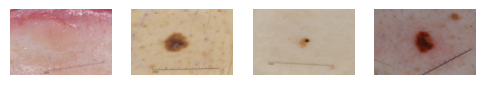

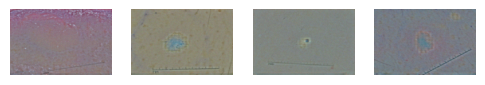

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


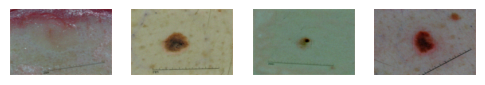

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


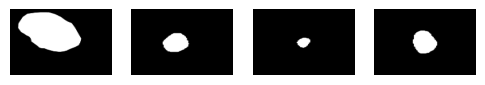

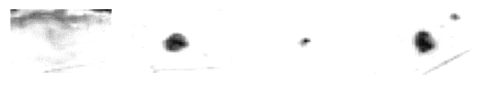

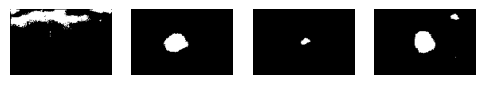

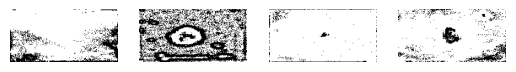

tensor([0, 0, 0, 0], device='cuda:0')


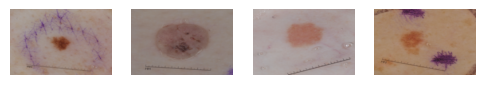

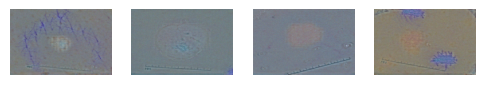

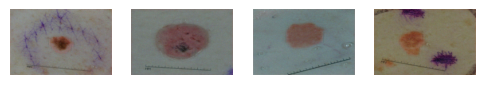

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


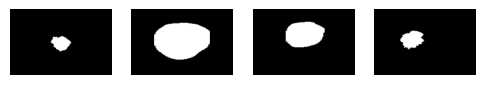

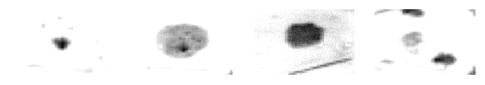

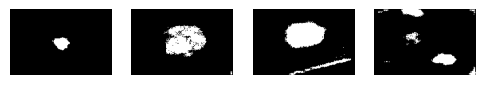

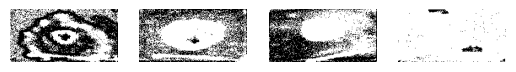

tensor([0, 0, 0, 0], device='cuda:0')


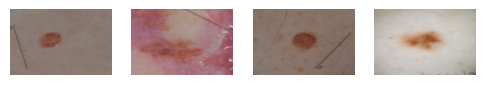

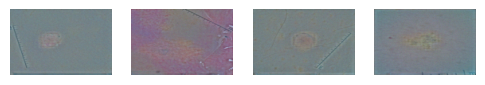

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


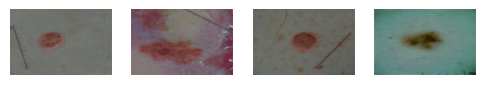

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


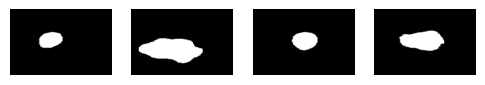

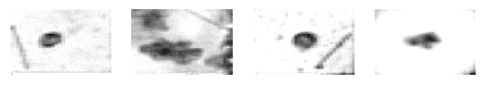

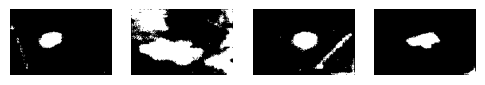

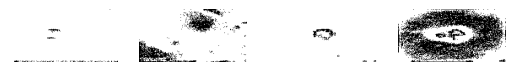

tensor([0, 0, 0, 0], device='cuda:0')


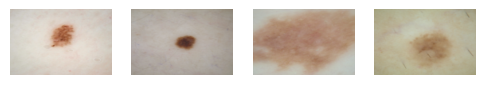

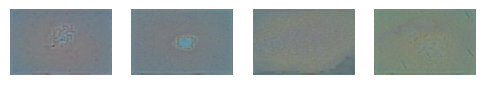

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


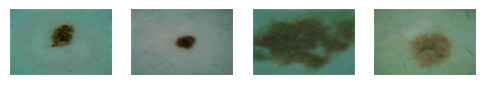

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


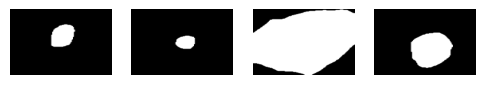

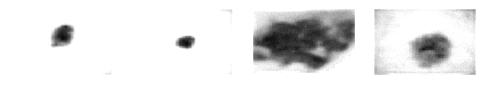

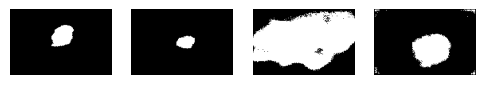

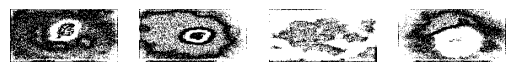

tensor([0, 0, 0, 0], device='cuda:0')


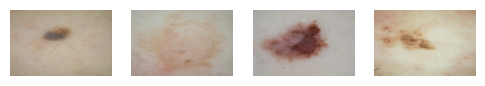

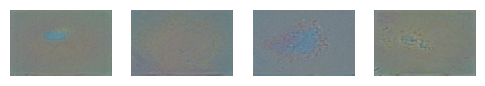

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


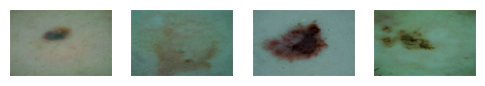

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


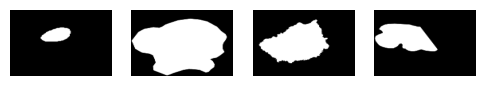

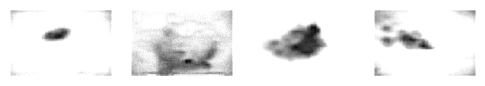

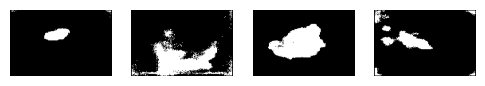

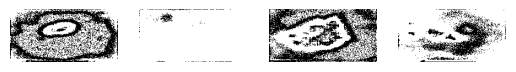

tensor([0, 0, 0, 0], device='cuda:0')


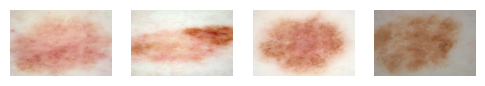

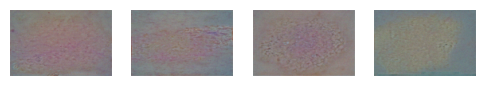

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


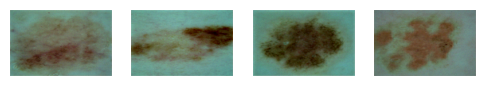

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


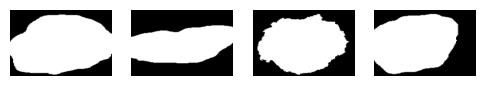

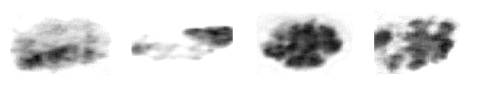

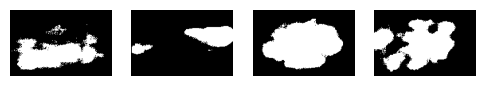

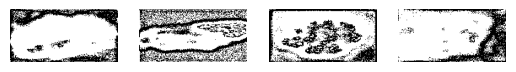

In [6]:
#进行噪声差异化计算
model_have_use = UNetModel(
    in_channels=3,
    model_channels=96,
    out_channels=3,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model_have_use.to(device)
model_no_use = UNetModel(
    in_channels=3,
    model_channels=96,
    out_channels=3,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model_no_use.to(device)
# 加载之前保存的模型参数
checkpoint1 = torch.load('.\MyDrive\DataSet\model_train8.pth',map_location=torch.device('cpu'))
checkpoint2 = torch.load('.\MyDrive\DataSet\model_no5.pth',map_location=torch.device('cpu'))
# 将参数加载到新模型中
model_have_use.load_state_dict(checkpoint1)
model_no_use.load_state_dict(checkpoint2)
dataset_final = datasets.ImageFolder('.\MyDrive\DataSet\images_isic18'
                                     '', transform=transform)
final_loader = torch.utils.data.DataLoader(dataset_final, batch_size=4, shuffle=False)
dataset_mask = datasets.ImageFolder('.\MyDrive\DataSet\masks_isic18', transform=transform)
mask_loader = torch.utils.data.DataLoader(dataset_mask, batch_size=4, shuffle=False)

with torch.no_grad():
    for step, ((images, labels),(masks,labels_mask)) in enumerate(zip(final_loader,mask_loader)):
        images = images.to(device)
        masks= masks.to(device)
        t = torch.randint(0,1,(4,), device=device).long()
        print(t)
        (loss, denoise_images,pnoise) = gaussian_diffusion.train_losses(model_have_use, images, t)
        (loss, denoise_images2,pnoise2) = gaussian_diffusion.train_losses(model_no_use, images, t)
        # 在显示之前，设置图像的显示大小
        plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
         # 绘制原图
        for idx, image in enumerate(images):
            image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            plt.imshow(image,aspect='auto')
            plt.axis("off")
        plt.show()  # 显示所有的图像
         # 绘制有病症方向的噪声
        plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, image in enumerate(pnoise):
            image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            plt.imshow(image,aspect='auto')
            plt.axis("off")
        plt.show()  # 显示所有的图像
        # 绘制无病症方向的噪声
        plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, image in enumerate(pnoise2):
            image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            plt.subplot(len(final_loader), 4, step *4 + idx + 1)
            plt.imshow(image,aspect='auto')
            plt.axis("off")
        plt.show()  # 显示所有的图像
        # 绘制专家标注
        plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, mask_batch in enumerate(masks):
            mask_batch = (mask_batch.squeeze().permute(1, 2, 0)+1)
            mask_batch = mask_batch.to("cpu").numpy()
            # 使用逻辑运算将图像二值化为0和255
            #print(mask_batch)

            #mask_batch = (mask_batch.squeeze().permute(1, 2, 0)+1)*127.5
            #mask_batch = mask_batch.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            #threshold = 128 # 阈值，可以根据需要调整
            #mask_batch=np.where(mask_batch>=threshold,255, 0)

            # 使用逻辑运算检查是否有数字大于255
            #has_number_greater_than_255 = (mask_batch > 2).any()

            # 打印结果
            #if has_number_greater_than_255:
                 #print("张量中存在数字大于2。")
            #else:
                 #print("张量中没有数字大于2。")

            plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            plt.imshow(mask_batch,cmap='gray',aspect='auto')
            plt.axis("off")
        plt.show()  # 显示所有的图像


       # 噪声差异
        plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, (d1, d2) in enumerate(zip(pnoise, pnoise2)):
            #image=d2-d1
            d1 = (d1.squeeze().permute(1, 2, 0) + 1) * 127.5
            d1 = d1.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            d1_tensor = torch.from_numpy(d1)
            d2 = (d2.squeeze().permute(1, 2, 0) + 1) * 127.5
            d2 = d2.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            d2_tensor = torch.from_numpy(d2)
            import numpy as np

# 将gray_image2转换为8位无符号整型（即灰度图像）
#gray_image2 = gray_image2.astype(np.uint8)

            # 将d1_tensor的数据类型转换为float
            d1_tensor_float = d1_tensor.float()
            d2_tensor_float = d2_tensor.float()

            # 使用加权求和获取灰度图像
            gray_d1 = torch.sum(d1_tensor_float * weights, dim=-1, keepdim=True)
            gray_d1 = gray_d1.cpu().numpy()  # 转换为NumPy数组
            gray_d1 = gray_d1 - np.min(gray_d1)
            gray_d2 = torch.sum(d2_tensor_float * weights, dim=-1, keepdim=True)
            gray_d2 = gray_d2.cpu().numpy()  # 转换为NumPy数组

            gray_d2 = gray_d2 - np.min(gray_d2)
            #image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            #image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组

    # 将NumPy数组转换为PyTorch张量
            #image_tensor = torch.from_numpy(image)

    # 将RGB图像转换为灰度图像
            #gray_image = torch.mean(image_tensor.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度
            #gray_d1 = torch.mean(d1_tensor.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度
            #gray_d2 = torch.mean(d2_tensor.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度
            gray_image2=gray_d2-gray_d1
            gray_image2 = (gray_image2 - np.min(gray_image2)) * (255 / np.max(gray_image2 - np.min(gray_image2)))
            gray_image2_brightened = np.clip(gray_image2*1.4 , 0, 255)
            #gray_image2_brightened = gray_image2_brightened.cpu().numpy()

            # 将gray_image2中的负数设置为0
# 将gray_image2转换为8位无符号整型（即灰度图像）
            #gray_image2 = gray_image2.astype(np.uint8)


            # 二值化灰度图像
            threshold = 179  # 阈值，可以根据需要调整
            binary_image=np.where(gray_image2_brightened<threshold,1, 0)
            #binary_image = binary_image.cpu().numpy().astype(int)
            #binary_d2 = binary_d2.cpu().numpy().astype(int)

            # 对二值图像进行外部白色区域的填充处理

            plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            plt.imshow( gray_image2_brightened.squeeze(),cmap='gray',aspect='auto')  # 使用灰度颜色映射
            plt.axis("off")
            #print(binary_image2)
        plt.show()  # 显示所有的图像
         # 噪声差异
        plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, (d1, d2) in enumerate(zip(pnoise, pnoise2)):
            #image=d2-d1
            d1 = (d1.squeeze().permute(1, 2, 0) + 1) * 127.5
            d1 = d1.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            d1_tensor = torch.from_numpy(d1)
            d2 = (d2.squeeze().permute(1, 2, 0) + 1) * 127.5
            d2 = d2.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            d2_tensor = torch.from_numpy(d2)
            import numpy as np

# 将gray_image2转换为8位无符号整型（即灰度图像）
#gray_image2 = gray_image2.astype(np.uint8)

            # 将d1_tensor的数据类型转换为float
            d1_tensor_float = d1_tensor.float()
            d2_tensor_float = d2_tensor.float()

            # 使用加权求和获取灰度图像
            gray_d1 = torch.sum(d1_tensor_float * weights, dim=-1, keepdim=True)
            gray_d1 = gray_d1.cpu().numpy()  # 转换为NumPy数组
            gray_d1 = gray_d1 - np.min(gray_d1)
            gray_d2 = torch.sum(d2_tensor_float * weights, dim=-1, keepdim=True)
            gray_d2 = gray_d2.cpu().numpy()  # 转换为NumPy数组

            gray_d2 = gray_d2 - np.min(gray_d2)
            #image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            #image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组

    # 将NumPy数组转换为PyTorch张量
            #image_tensor = torch.from_numpy(image)

    # 将RGB图像转换为灰度图像
            #gray_image = torch.mean(image_tensor.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度
            #gray_d1 = torch.mean(d1_tensor.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度
            #gray_d2 = torch.mean(d2_tensor.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度
            gray_image2=gray_d2-gray_d1
            gray_image2 = (gray_image2 - np.min(gray_image2)) * (255 / np.max(gray_image2 - np.min(gray_image2)))
            gray_image2_brightened = np.clip(gray_image2*1.4 , 0, 255)
            #gray_image2_brightened = gray_image2_brightened.cpu().numpy()

            # 将gray_image2中的负数设置为0
# 将gray_image2转换为8位无符号整型（即灰度图像）
            #gray_image2 = gray_image2.astype(np.uint8)


            # 二值化灰度图像
            threshold = 179  # 阈值，可以根据需要调整
            binary_image=np.where(gray_image2_brightened<threshold,1, 0)
            #binary_image = binary_image.cpu().numpy().astype(int)
            #binary_d2 = binary_d2.cpu().numpy().astype(int)

            # 对二值图像进行外部白色区域的填充处理

            plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            plt.imshow( binary_image.squeeze(),cmap='gray',aspect='auto')  # 使用灰度颜色映射
            plt.axis("off")
            #print(binary_image2)
        plt.show()  # 显示所有的图像
        for idx, (d1, d2) in enumerate(zip(pnoise, pnoise2)):
            d1 = (d1.squeeze().permute(1, 2, 0) + 1) * 127.5
            d1 = d1.to("cpu").numpy().astype(int)
            d2 = (d2.squeeze().permute(1, 2, 0) + 1) * 127.5
            d2 = d2.to("cpu").numpy().astype(int)
            d1 = d1.astype(np.uint8)
            d2 = d2.astype(np.uint8)


    # 将RGB图像转换为灰度图像
            gray_d1 = cv2.cvtColor(d1, cv2.COLOR_RGB2GRAY)
            gray_d2 = cv2.cvtColor(d2, cv2.COLOR_RGB2GRAY)

            difference_image = gray_d2 - gray_d1
            difference_image = np.clip(difference_image*1.3 , 0, 255)
            difference_image_normalized = cv2.normalize(difference_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # 使用OpenCV的自适应阈值二值化
            binary_image = cv2.adaptiveThreshold(difference_image_normalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19  , 2)

            plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            plt.imshow(binary_image, cmap='gray', aspect='auto')
            plt.axis("off")
        plt.show()  # 显示所有的图像


In [ ]:
#进行噪声差异化计算
model_have_use = UNetModel(
    in_channels=3,
    model_channels=96,
    out_channels=3,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model_have_use.to(device)
model_no_use = UNetModel(
    in_channels=3,
    model_channels=96,
    out_channels=3,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model_no_use.to(device)
# 加载之前保存的模型参数
checkpoint1 = torch.load('.\MyDrive\DataSet\model_train9.pth')
checkpoint2 = torch.load('.\MyDrive\DataSet\model_no5.pth')
# 将参数加载到新模型中
model_have_use.load_state_dict(checkpoint1)
model_no_use.load_state_dict(checkpoint2)
dataset_final = datasets.ImageFolder('.\MyDrive\DataSet\images_isic2018'
                                     '', transform=transform)
final_loader = torch.utils.data.DataLoader(dataset_final, batch_size=batch_size, shuffle=False)
dataset_mask = datasets.ImageFolder('.\MyDrive\DataSet\isic2018_test_truth', transform=transform)
mask_loader = torch.utils.data.DataLoader(dataset_mask, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    dice_average=0
    for step, ((images, labels),(masks,labels_mask)) in enumerate(zip(final_loader,mask_loader)):
        images = images.to(device)
        masks= masks.to(device)
        t = torch.randint(0,1,(batch_size,), device=device).long()
        print(t)
        (loss, denoise_images,pnoise) = gaussian_diffusion.train_losses(model_have_use, images, t)
        (loss, denoise_images2,pnoise2) = gaussian_diffusion.train_losses(model_no_use, images, t)
        # 在显示之前，设置图像的显示大小
        #plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
         # 绘制原图
        for idx, image in enumerate(images):
            image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            #plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            #plt.imshow(image,aspect='auto')
            #plt.axis("off")
        #plt.show()  # 显示所有的图像
         # 绘制有病症方向的噪声
        #plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, image in enumerate(pnoise):
            image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            #plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            #plt.imshow(image,aspect='auto')
            #plt.axis("off")
        #plt.show()  # 显示所有的图像
        # 绘制无病症方向的噪声
        #plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, image in enumerate(pnoise2):
            image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            #plt.subplot(len(final_loader), 4, step *4 + idx + 1)
            #plt.imshow(image,aspect='auto')
            #plt.axis("off")
        #plt.show()  # 显示所有的图像
        # 绘制专家标注
        #plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, mask_batch in enumerate(masks):
            mask_batch = (mask_batch.squeeze().permute(1, 2, 0)+1)
            mask_batch = mask_batch.to("cpu").numpy()
            # 使用逻辑运算将图像二值化为0和255
            #print(mask_batch)

            #mask_batch = (mask_batch.squeeze().permute(1, 2, 0)+1)*127.5
            #mask_batch = mask_batch.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            #threshold = 128 # 阈值，可以根据需要调整
            #mask_batch=np.where(mask_batch>=threshold,255, 0)

            # 使用逻辑运算检查是否有数字大于255
            #has_number_greater_than_255 = (mask_batch > 2).any()

            # 打印结果
            #if has_number_greater_than_255:
                 #print("张量中存在数字大于2。")
            #else:
                 #print("张量中没有数字大于2。")

            #plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            #plt.imshow(mask_batch,cmap='gray',aspect='auto')
            #plt.axis("off")
        #plt.show()  # 显示所有的图像

       # 噪声差异
        #plt.figure(figsize=(6, 6))  # 12x6英寸的图像大小，可以根据需要调整
        for idx, (d1, d2) in enumerate(zip(pnoise, pnoise2)):
           #image=d2-d1
            d1 = (d1.squeeze().permute(1, 2, 0) + 1) * 127.5
            d1 = d1.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            d1_tensor = torch.from_numpy(d1)
            d2 = (d2.squeeze().permute(1, 2, 0) + 1) * 127.5
            d2 = d2.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组
            d2_tensor = torch.from_numpy(d2)
            import numpy as np

# 将gray_image2转换为8位无符号整型（即灰度图像）
#gray_image2 = gray_image2.astype(np.uint8)

            # 将d1_tensor的数据类型转换为float
            d1_tensor_float = d1_tensor.float()
            d2_tensor_float = d2_tensor.float()

            # 使用加权求和获取灰度图像
            gray_d1 = torch.sum(d1_tensor_float * weights, dim=-1, keepdim=True)
            gray_d1 = gray_d1.cpu().numpy()  # 转换为NumPy数组
            gray_d1 = gray_d1 - np.min(gray_d1)
            gray_d2 = torch.sum(d2_tensor_float * weights, dim=-1, keepdim=True)
            gray_d2 = gray_d2.cpu().numpy()  # 转换为NumPy数组
            gray_d2 = gray_d2 - np.min(gray_d2)
            #image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            #image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组

    # 将NumPy数组转换为PyTorch张量
            #image_tensor = torch.from_numpy(image)

    # 将RGB图像转换为灰度图像
            #gray_image = torch.mean(image_tensor.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度
            #gray_d1 = torch.mean(d1_tensor.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度
            #gray_d2 = torch.mean(d2_tensor.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度
            gray_image2=gray_d2-gray_d1
            gray_image2 = (gray_image2 - np.min(gray_image2)) * (255 / np.max(gray_image2 - np.min(gray_image2)))
            gray_image2_brightened = np.clip(gray_image2 *1, 0, 255)
            # 将gray_image2中的负数设置为0
# 将gray_image2转换为8位无符号整型（即灰度图像）
            #gray_image2 = gray_image2.astype(np.uint8)

            # 二值化灰度图像
            threshold = 179  # 阈值，可以根据需要调整
            binary_image=np.where(gray_d2<threshold,1, 0)
            #binary_image = binary_image.cpu().numpy().astype(int)
            #binary_d2 = binary_d2.cpu().numpy().astype(int)

            # 对二值图像进行外部白色区域的填充处理

            #image=d2-d1
            #image = (image.squeeze().permute(1, 2, 0) + 1) * 127.5
            #image = image.to("cpu").numpy().astype(int)  # 将图像从GPU移回CPU并转换为NumPy数组

    # 将NumPy数组转换为PyTorch张量
            #image_tensor = torch.from_numpy(image)

    # 将RGB图像转换为灰度图像
            #gray_image = torch.mean(image_tensor.float(), dim=2, keepdim=True)  # 使用平均值方法将RGB转为灰度

            # 二值化灰度图像
            #threshold = 115  # 阈值，可以根据需要调整
            #binary_image = (gray_image < threshold).float()   # 大于阈值的像素设为255，小于等于阈值的像素设为0
            #binary_image = binary_image.cpu().numpy().astype(int)
            #print(binary_image)

            #plt.subplot(len(final_loader), 4, step * 4 + idx + 1)
            #plt.imshow(binary_image.squeeze(),cmap='gray',aspect='auto')  # 使用灰度颜色映射
            #plt.axis("off")
            #print(binary_image2)
        #plt.show()  # 显示所有的图像
        # 计算 Dice 系数
        intersection = np.logical_and(binary_image, mask_batch)*255
        has_number_greater_than_255 = (intersection > 255).any()

        # 打印结果
        #if has_number_greater_than_255:
            #print("张量中存在数字大于255。
        #else:
            #print("张量中没有数字大于255。")

        #print(np.sum(intersection))
        dice = (2.0 * np.sum(intersection)) / (np.sum(binary_image)*255 + np.sum(mask_batch)*255)
        #print(np.sum(mask_batch))
        #print(np.sum(binary_image))
        print(f"Step {step}, Image {idx}, Dice Score: {dice}")
        #print(binary_image)
        dice_average=dice_average+dice*1/250
        print(f"dice_average:{dice_average}")


tensor([0, 0, 0, 0], device='cuda:0')
Step 0, Image 3, Dice Score: 0.29832739893184507
dice_average:0.0011933095957273802
tensor([0, 0, 0, 0], device='cuda:0')
Step 1, Image 3, Dice Score: 0.28169894954385183
dice_average:0.0023201053939027874
tensor([0, 0, 0, 0], device='cuda:0')
Step 2, Image 3, Dice Score: 0.4050108475221899
dice_average:0.003940148783991547
tensor([0, 0, 0, 0], device='cuda:0')
Step 3, Image 3, Dice Score: 0.5334553375749121
dice_average:0.006073970134291196
tensor([0, 0, 0, 0], device='cuda:0')
Step 4, Image 3, Dice Score: 0.5537527543804985
dice_average:0.00828898115181319
tensor([0, 0, 0, 0], device='cuda:0')
Step 5, Image 3, Dice Score: 0.8085189975379911
dice_average:0.011523057141965155
tensor([0, 0, 0, 0], device='cuda:0')
Step 6, Image 3, Dice Score: 0.5828560014157878
dice_average:0.013854481147628306
tensor([0, 0, 0, 0], device='cuda:0')
Step 7, Image 3, Dice Score: 0.6995609757928721
dice_average:0.016652725050799795
tensor([0, 0, 0, 0], device='cuda:0')